# Applications of ML
---

## Applications

There are a *ton* of machine learning applications -- too many to discuss in just one lecture...

<img src=https://static.javatpoint.com/tutorial/machine-learning/images/applications-of-machine-learning.png>

Machine learning is being applied in just about every area possible (e.g., finance, medicine, construction, security, agriculture, mining, aerospace, etc.). You can go down rabbit holes online for hours just learning about all the new and interesting applications.

## Choosing the right algorithm

One of the biggest challenges when tackling any machine learning algorithm is choosing the right algorithm. At this stage of your career this will probably feel daunting and difficult, but over time and with more and more experience you will get better at doing this quickly and with more confidence.

Below are GUIDES! You don't need to choose just one. You can use a combination of techniques. Performance-based evaluation is usually the best.

Speed and memory are also considersations. (Note: training resources are different than prediction resources)

[Hi-res link to image below](https://s3.amazonaws.com/assets.datacamp.com/email/other/ML+Cheat+Sheet_2.pdf)

### Sci-kit learn cheat sheet
[Sci-kit learn cheat sheet](https://scikit-learn.org/stable/machine_learning_map)

## Be smart about feature engineering

You've learned a bit about feature engineering and put it into practice, but you've probably been limited to things like polynomial expansion, principal component analysis, etc. Most problems you'll be solving are rooted in real systems (often physical), so take advantage of the properties and relationships of the system instead of just blindly using the data.

> Remember: ML algorithms look for patterns in the data. Sometimes you have knowledge about the existing features that would help predict the target variable. You can "implement" this knowledge via feature engineering.
> - e.g.: dates/seasonality
> - e.g.: height/weight vs obesity

Let's take a look at an example...

Suppose we have a simple robotic manipulator (robot arm):

<img src=https://journals.sagepub.com/cms/10.1177/1729881416677695/asset/images/large/10.1177_1729881416677695-fig1.jpeg width=500>

In this case we can define the position of the tip with these equations:

$x = a_2 \cos{\theta_1} \cos{\theta_2} + a_3 \cos{\theta_1} \cos{(\theta_2 + \theta_3)}$

$y = a_2 \sin{\theta_1} \cos{\theta_2} + a_3 \sin{\theta_1} \cos{(\theta_2 + \theta_3)}$

$z = a_2 \sin{\theta_2} + a_3 \sin{(\theta_2 + \theta_3)}$

This inputs are the joint angles $\theta_1$, $\theta_2$, and $\theta_3$, and the outputs are the tip position $(x,y,z)$.

Let's try to build a neural network (multi-layer perceptron) regressor to model the relationship between joint angles and tip position.

First we'll set up the data based on the physical equations -- imagine we actually recorded these from an experiment.

In [59]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter('ignore', category=ConvergenceWarning)

# arm lengths (not shown to model)
a1 = 0.54
a2 = 0.36

#sample size
n = 1000

# features
q1 = 2 * np.pi * np.random.rand(n) # n random angles
q2 = 2 * np.pi * np.random.rand(n) # n random angles
q3 = 2 * np.pi * np.random.rand(n) # n random angles

# targets
x_end = a1 * np.cos(q1) * np.cos(q2) + a2 * np.cos(q1) * np.cos(q2 + q3) # x-coord
y_end = a1 * np.sin(q1) * np.cos(q2) + a2 * np.sin(q1) * np.cos(q2 + q3) # y-coord
z_end = a1 * np.sin(q2) + a2 * np.sin(q2 + q3) # z-coord

X = np.concatenate([q1.reshape(-1, 1), q2.reshape(-1, 1), q3.reshape(-1, 1)], axis=1)
y = np.concatenate([x_end.reshape(-1, 1), y_end.reshape(-1, 1), z_end.reshape(-1, 1)], axis=1)

In [60]:
print(X.shape) # q1, q2, q3 (angles)
X[:5]

(1000, 3)


array([[3.88778441, 4.55814593, 0.1644068 ],
       [4.48017209, 2.62321995, 3.74850116],
       [3.47597047, 3.84303244, 2.09186352],
       [0.7889007 , 0.84045311, 2.14174954],
       [2.77071034, 5.74891654, 5.7826741 ]])

In [61]:
print(y.shape) # x, y, z (coordinates)
y[:5]

(1000, 3)


array([[ 0.05823018,  0.05383429, -0.89357058],
       [ 0.0254227 ,  0.10750326,  0.2993836 ],
       [ 0.07002299,  0.02432765, -0.47133637],
       [ 0.00338992,  0.00341375,  0.45940831],
       [-0.60450378,  0.23507856, -0.5844844 ]])

Next, let's setup and train the neural network.

In [62]:
from sklearn.model_selection import train_test_split

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=93)

mlp_basic = MLPRegressor(hidden_layer_sizes=(100,))
mlp_basic.fit(X_train, y_train)

MLPRegressor()

Now we can predict the outputs and evaluate the error.

In [63]:
y_pred = mlp_basic.predict(X_test)

print(mean_absolute_error(y_test, y_pred))

0.19230568425846584


In [64]:
mlp_basic.score(X_test, y_test)

np.float64(0.49977897772056296)

But... what if instead of just passing the joint angles as inputs, we recognized that when converting between angles and positions there is trigonometry involved and take advantage of that to engineer new features.

Instead of just using the 3 joint angles as inputs, we'll compute the sine and cosine of each angle and use all of those as inputs. So our inputs will be $(\cos{\theta_1}, \cos{\theta_2}, \cos{\theta_3}, \sin{\theta_1}, \sin{\theta_2},  \sin{\theta_3})$.


In [65]:
X_feng = np.concatenate([np.cos(X), np.sin(X)], axis=1)

print(X_feng.shape) # cos(q1), cos(q2), cos(q3), sin(q1), sin(q2), sin(q3)
X_feng[0]

(1000, 6)


array([-0.7342794 , -0.15363218,  0.98651562, -0.67884738, -0.98812811,
        0.16366716])

In [66]:
#split data
X_feng_train, X_feng_test, y_train, y_test = train_test_split(X_feng, y, test_size=0.2, random_state=93)

mlp_feng = MLPRegressor(hidden_layer_sizes=(100,))
mlp_feng.fit(X_feng_train, y_train)

y_pred_feng = mlp_feng.predict(X_feng_test)

mean_absolute_error(y_test, y_pred_feng)

np.float64(0.07565615979291493)

In [67]:
mlp_feng.score(X_feng_test, y_test)

np.float64(0.8970704237216963)

Recognize these trigonometric identities:

$\cos(\theta_1 + \theta_2) = \cos\theta_1\cos\theta_2 - \sin\theta_1\sin\theta_2$

In [70]:
q1r = q1.reshape(-1, 1)
q2r = q2.reshape(-1, 1)
q3r = q3.reshape(-1, 1)

X = np.concatenate([(q1r), (q2r), (q3r), (q1r + q2r), (q1r + q3r), (q2r + q3r), (q1r + q2r + q3r)], axis=1) # parentheses for readability
X_feng = np.concatenate([np.cos(X), np.sin(X)], axis=1)
X_feng_train, X_feng_test, y_train, y_test = train_test_split(X_feng, y, test_size=0.2, random_state=93)

mlp_feng = MLPRegressor(hidden_layer_sizes=(100,))
mlp_feng.fit(X_feng_train, y_train)

y_pred_feng = mlp_feng.predict(X_feng_test)

mean_absolute_error(y_test, y_pred_feng)
# performs about the same as previous

np.float64(0.03940224163327985)

In [71]:
mlp_feng.score(X_feng_test, y_test)

np.float64(0.9756462937298789)

In [72]:
q1r = q1.reshape(-1,1)
q2r = q2.reshape(-1,1)
q3r = q3.reshape(-1,1)
X = np.concatenate([
    (q1r), (q2r), (q3r), (q1r + q2r), (q1r + q3r), (q2r + q3r), (q1r + q2r + q3r), (q1r - q2r), (q1r - q3r), (q2r - q3r), (q1r - q2r + q3r), (q1r + q2r - q3r), (q1r - q2r - q3r)],
    axis=1)
X_feng = np.concatenate([np.cos(X), np.sin(X)], axis=1)
X_feng_train, X_feng_test, y_train, y_test = train_test_split(X_feng, y, test_size=0.2, random_state=93)

mlp_feng = MLPRegressor(hidden_layer_sizes=(100,))
mlp_feng.fit(X_feng_train,y_train)

y_pred_feng = mlp_feng.predict(X_feng_test)

mean_absolute_error(y_test, y_pred_feng)
# might lead to over-fitting

np.float64(0.04455534249137353)

In [73]:
mlp_feng.score(X_feng_test, y_test)

np.float64(0.9714269905638576)

### A classification example:

In [74]:
from sklearn.datasets import make_circles

X, y = make_circles(5000, noise=0.07, random_state=93)

In [75]:
X[:5] # X, y coordinates

array([[-0.27842624, -0.72286493],
       [ 0.30015298, -0.79330008],
       [-0.58052059,  0.7358877 ],
       [ 0.47367919, -0.51108958],
       [-0.54189205, -0.56904716]])

In [76]:
y[:5]

array([1, 1, 0, 1, 1])

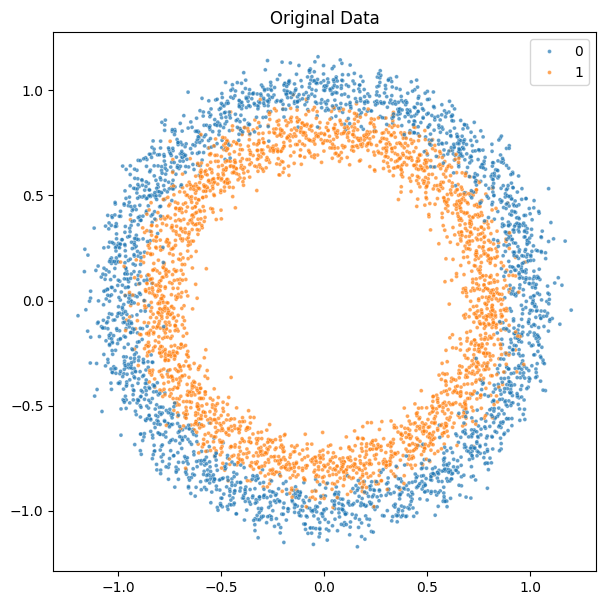

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=8, alpha=0.7)
plt.title('Original Data')

plt.show()

Accuracy: 0.553


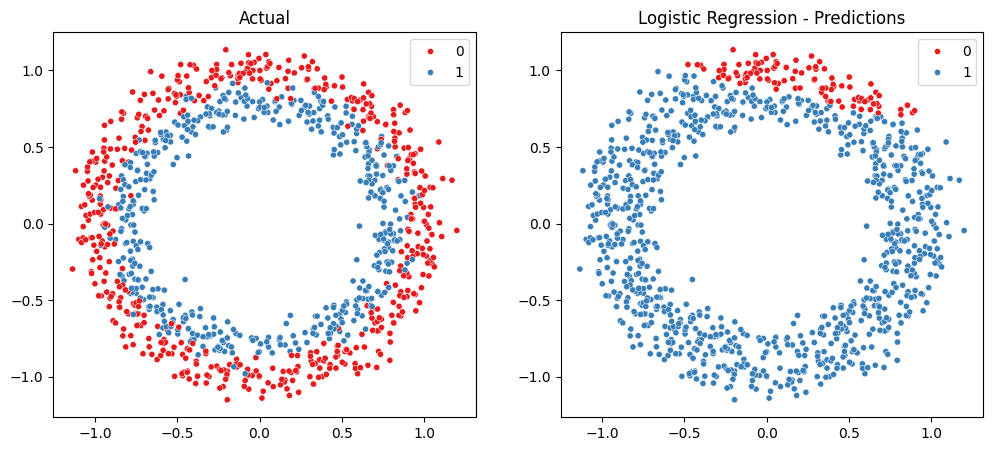

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=93)

model = LogisticRegression()
model.fit(X_train, y_train)

y_log_reg_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_log_reg_pred)}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette='Set1', s=20, ax=axes[0])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_log_reg_pred, palette='Set1', s=20, ax=axes[1])

axes[0].set_title('Actual')
axes[1].set_title('Logistic Regression - Predictions')

plt.show()

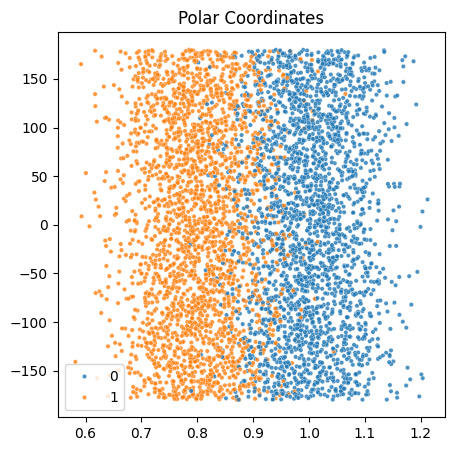

In [79]:
# What if we used polar co-ordinates instead?
# cartesian coordinates (x, y)
# polar coordinates (radius, theta)
W = np.zeros_like(X) # initialize to all zeros

# distance from center
W[:, 0] = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)

# angle
W[:, 1] = np.arctan2(X[:, 1], X[:, 0]) # angle

plt.figure(figsize=(5, 5))
sns.scatterplot(x=W[:, 0], y=(180.0 / np.pi) * W[:, 1], hue=y, s=10, alpha=0.8)
plt.title('Polar Coordinates')

plt.show()

Accuracy: 0.917


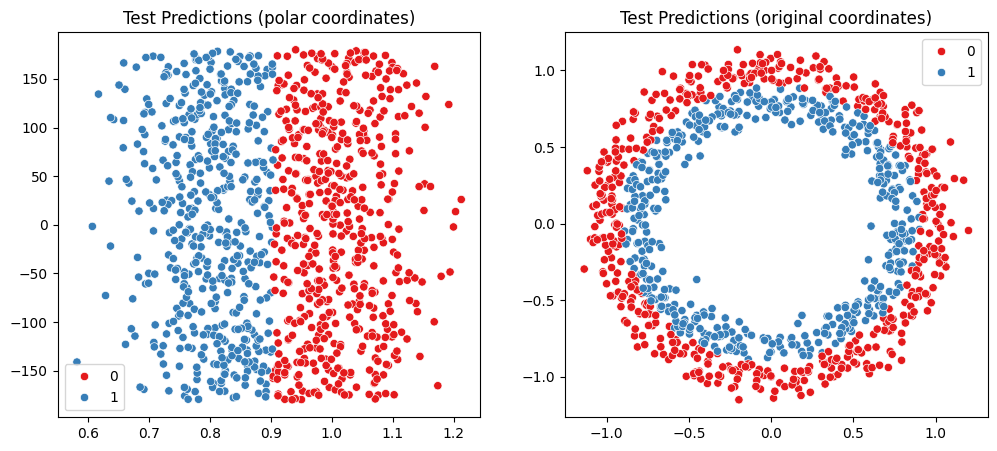

In [83]:
W_train, W_test, y_train, y_test = train_test_split(W, y, test_size=0.2, random_state=93)

model_polar = LogisticRegression()
model_polar.fit(W_train, y_train)

y_polar_pred = model_polar.predict(W_test)

print(f'Accuracy: {accuracy_score(y_test, y_polar_pred)}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=W_test[:, 0], y=(180.0 / np.pi) * W_test[:, 1], hue=y_polar_pred, palette='Set1', ax=axes[0])
sns.scatterplot(x=W_test[:, 0] * np.cos(W_test[:, 1]), y=W_test[:, 0] * np.sin(W_test[:, 1]), hue=y_polar_pred, palette='Set1', ax=axes[1])

axes[0].set_title('Test Predictions (polar coordinates)')
axes[1].set_title('Test Predictions (original coordinates)')

plt.show()

We can see that we get a high accuracy now. Why? Because we didn't force the model to have to learn the trigonometric relationships that are the basis for the equations of the physical system. We allowed it to take a shortcut by being smart about what inputs to pass in.

> Don't force machine learning to do extra work when you can prepare the data in a more "digestable" way!

### Note: Sometimes the model is "strong" or "sophisticated" enough to learn these patterns. Sometimes it isn't!

Notice we only used logisitic regression in this circle data example. Recall logistic regression can only learn linear patterns, which is why we needed to feature engineer useful (linear) features to get good results.

However, some models are smart enough to learn non-linear patterns, and so sometimes the model (e.g. neural networks) "learns" the useful feature engineering without you knowing about it.

Let's try using the original (x,y) data and a neural network (MLP) that will try to learn the circular nature of the data.

Accuracy: 0.916


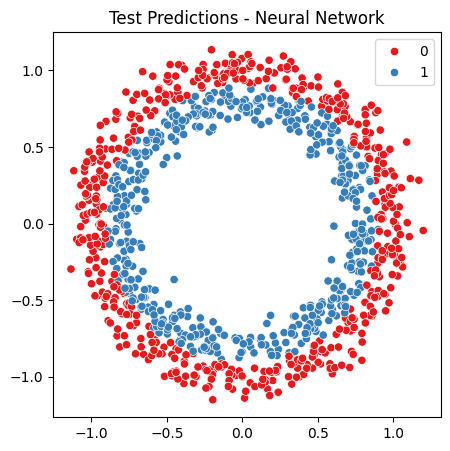

In [84]:
from sklearn.neural_network import MLPClassifier

NN_model = MLPClassifier(hidden_layer_sizes=(100,))
NN_model.fit(X_train, y_train) # original X, y data

y_nn_pred = NN_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_nn_pred)}')

plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_nn_pred, palette='Set1')
plt.title('Test Predictions - Neural Network')

plt.show()
# Note: there is randomness involved with neural networks, so you can try re-running this cell multiple times.

Accuracy: 0.914


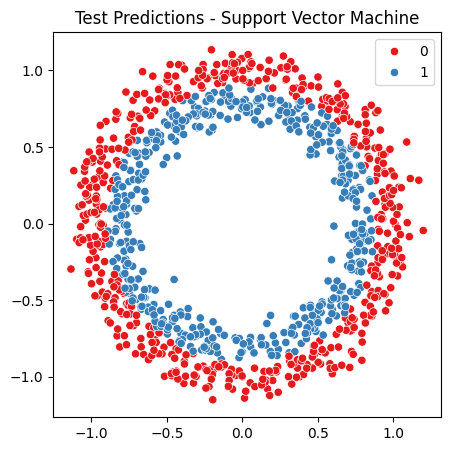

In [85]:
from sklearn.svm import SVC

svc_model = SVC(kernel='rbf')
svc_model.fit(X_train, y_train) # original X, y data

y_svc_pred = svc_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_svc_pred)}')

plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_svc_pred, palette='Set1')
plt.title('Test Predictions - Support Vector Machine')

plt.show()

## Be smart about performance evaluation (metrics)

It's easy to think that accuracy tells you everything, or F1 score, or R-adjusted, etc. But in many cases you have to be very careful about how you judge accuracy.

The easiest example that you've probably heard about already is if we are trying to predict something like bank fraud and it happens only 0.1% of the time. You can easily end up with a ML solution that just predicts `False` every time -- it will be 99.9% accurate!

Let's look at a different example:

Suppose we want to build an ML algorithm to predict if plants need to be watered or not. We have training data that specifies particular conditions like temperature, humidity, sunlight, etc., and our output is simply classification (1 or 0, irrigate or not).

What if we had the following true set of irrigation outputs:

`[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]`

...so basically, water every second day...

And what if we had an ML algorithm predict this (case 1):

- Case 1: `[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]`

Okay well that's just 100% accurate -- great!

But what if it predicted this (case 2):

- Case 2: `[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]`

...that's 0% accurate... but do you think the plants would grow poorly?

What about with this (case 3)?

- Case 3: `[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]`

...or this (case 4)?

- Case 4: `[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`

So, with case 1 we get 100% accuracy, with case 2 we get 0% accuracy, and with cases 3 and 4 we get 50% accuracy. Case 1 is obviously good, but are cases 3 and 4 equally good, and both (or either) better than case 2?

Clearly accuracy directly on the output classification is not the best way to evalute this problem. What if instead we looked at the *cumulative* irrigation decisions?

> Note: this is useful for time-series data, where a data point (row) in your data is DEPENDENT on the previous data points (rows).
>
> I.e. the ordering of your rows matter.

Here would be the true results:

`[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]`

And for each case:

- Case 1: `[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]`
- Case 2: `[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6]`
- Case 3: `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]`
- Case 4: `[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`

If we judged based on the *mean absolute error* we would get:

- Case 1: 0
- Case 2: 0.5
- Case 3: 3.25
- Case 4: 3.5

So now the case 2 model is appropriately showing up as being better than case 3 or 4!

### ROC curves

Another thing to consider is the fact that most classifiers will actually predict a *probability* for each possible class -- and then, by default, pick the class that has the highest probability. In the case where you have just 2 classes (i.e., yes/no answer) then the classifier predicts the probability the output is true and we just threshold at 0.5 (i.e., if probability is higher than 0.5 then we say it is true).

Does that make sense? Maybe... or maybe not! Our statistical hypothesis tests used a threshold p-value of 0.05... so maybe in some cases we want to choose a different threshold. E.g. Predict True if the probability is > 0.7 (instead of the default 0.5).



Text(0.5, 1.0, 'Test Predictions - Polar Model with Probabilities')

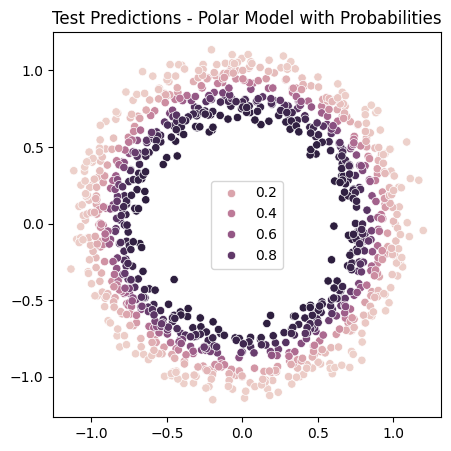

In [86]:
# reminder of code ran earlier
model_polar = LogisticRegression()
model_polar.fit(W_train, y_train)
y_polar_pred = model_polar.predict(W_test)

# we can get the probabilities instead of the binary predictions
y_polar_proba = model_polar.predict_proba(W_test)

# scatter plot of predictions in test set (in original coordinates) (x=r*cos, y=r*sin)
# with color representing probability of class 0

plt.figure(figsize=(5, 5))
sns.scatterplot(x=W_test[:, 0] * np.cos(W_test[:, 1]), y=W_test[:, 0] * np.sin(W_test[:, 1]), hue=y_polar_proba[:, 1])
plt.title('Test Predictions - Polar Model with Probabilities')

In [87]:
# Create a custome predict function that allows us to specify a threshold
def custom_predict(X=W_test, model=model_polar, threshold=0.5):
    probs = model.predict_proba(X)
    return (probs[:, 1] >= threshold).astype(int)

In [88]:
reg_threshold_pred = custom_predict()
high_threshold_pred = custom_predict(threshold=0.8)
low_threshold_pred = custom_predict(threshold=0.2)

print(f"{22 * '-'}Original {22 * '-'}")
print(classification_report(y_test, y_polar_pred))

print(f"{18 * '-'}Regular Threshold{18 * '-'}")
print(classification_report(y_test, reg_threshold_pred))

print(f"{19 * '-'}High Threshold {19 * '-'}")
print(classification_report(y_test, high_threshold_pred))

print(f"{20 * '-'}Low Threshold{20 * '-'}")
print(classification_report(y_test, low_threshold_pred))

----------------------Original ----------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       527
           1       0.91      0.92      0.91       473

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

------------------Regular Threshold------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       527
           1       0.91      0.92      0.91       473

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

-------------------High Threshold -------------------
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       527
           1       0.98      0.71      0.82       473

    accuracy        

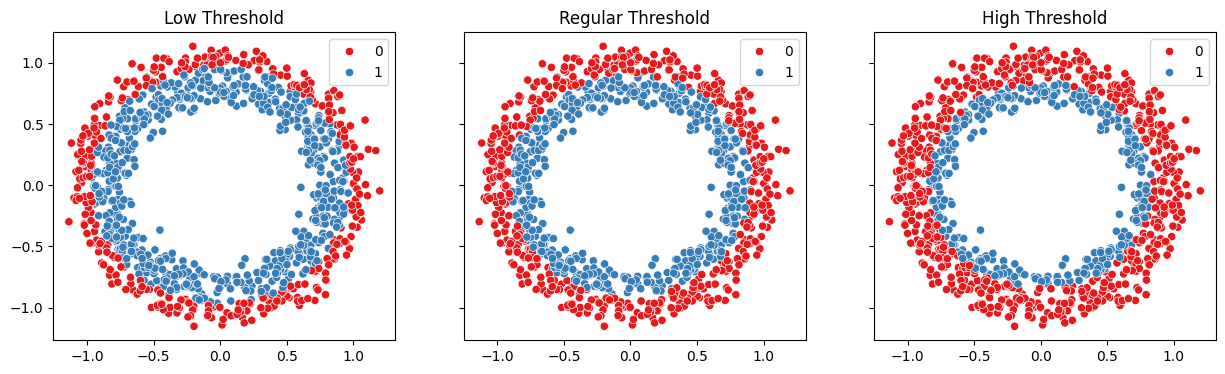

In [89]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 4))

sns.scatterplot(x=W_test[:, 0] * np.cos(W_test[:, 1]), y=W_test[:, 0] * np.sin(W_test[:, 1]), hue=low_threshold_pred, palette='Set1', ax=axes[0])
sns.scatterplot(x=W_test[:, 0] * np.cos(W_test[:, 1]), y=W_test[:, 0] * np.sin(W_test[:, 1]), hue=reg_threshold_pred, palette='Set1', ax=axes[1])
sns.scatterplot(x=W_test[:, 0] * np.cos(W_test[:, 1]), y=W_test[:, 0] * np.sin(W_test[:, 1]), hue=high_threshold_pred, palette='Set1', ax=axes[2])

axes[0].set_title('Low Threshold')
axes[1].set_title('Regular Threshold')
axes[2].set_title('High Threshold')

plt.show()

By doing this we can control how sensitive our model is. Make it too sensitive and it will get a lot of the true positives correct but will mistakenly cause many false positives. Make it not sensitive enough and you will avoid false positives but also miss many of the true positives. One way to see how the choice of threshold value affects the true positive and false positive rates (i.e., the % of true and false positives that happen) is to use receiver operating characteristic curves -- or ROC curves.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png width=500>

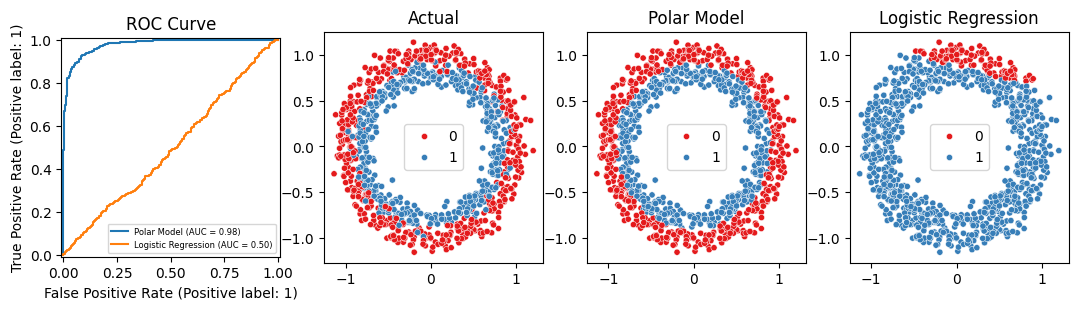

In [90]:
from sklearn.metrics import RocCurveDisplay

fig, axes = plt.subplots(1, 4, figsize=(13, 3))

RocCurveDisplay.from_estimator(model_polar, W_test, y_test, name='Polar Model', ax=axes[0])
RocCurveDisplay.from_estimator(model, W_test, y_test, name='Logistic Regression', ax=axes[0])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette='Set1', s=20, ax=axes[1])
sns.scatterplot(x=W_test[:, 0] * np.cos(W_test[:, 1]), y=W_test[:, 0] * np.sin(W_test[:, 1]), hue=reg_threshold_pred, palette='Set1', s=20, ax=axes[2])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_log_reg_pred, palette='Set1', s=20, ax=axes[3])

axes[0].set_title('ROC Curve')
axes[1].set_title('Actual')
axes[2].set_title('Polar Model')
axes[3].set_title('Logistic Regression')

axes[0].legend(fontsize=6)

plt.show()

In [91]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, model_polar.predict_proba(W_test)[:, 1])
auc(fpr, tpr)

np.float64(0.9785213683099919)

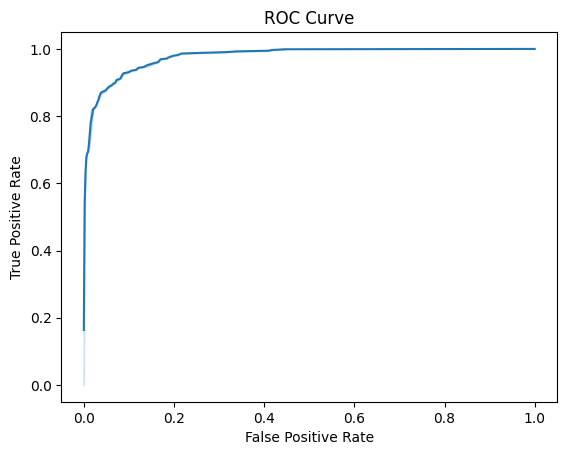

In [92]:
sns.lineplot(x=fpr, y=tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()